In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.set_cmap('viridis')
import scipy.io as sio
import time

In [2]:
import sys
sys.path.append('/home/matsui-k/projects/d-rcn')

In [9]:
from scripts.core import TN_utils, models, compiling, optimizers
reload(TN_utils)

<module 'scripts.core.TN_utils' from '/home/matsui-k/projects/d-rcn/scripts/core/TN_utils.py'>

In [4]:
fe_vec, gt_vec, mask_vec, vol_shape = TN_utils.load_hardi(i_order=0, i_indiv=0, mask_thresh=0.5)

(430080, 31, 1) (430080, 1) (430080,)


In [5]:
data_set, norm_coef, gt_norm_coef = TN_utils.preprocess(fe_vec, gt_vec, mask_vec)

(21485, 1, 31)
(21485, 1)
(5372, 1, 31)
(5372, 1)


In [6]:
rcn_2layer = models.Rcn2layer_wo_bn(
    n_tensors_list=[fe_vec.shape[1], 1024],
    func_key_list=["relu", "linear"],
    l2_reg=0.,
    gamma_scale=10**-2,
    drop_list=[1., 1.],
    bias_scale=0.)
                            
result = compiling.compile_bn(
    data_set=data_set,
    model=rcn_2layer,
    make_updates=optimizers.adam)
f_train, f_training_error, f_test_error, f_output, s_input, s_target, s_test_input, s_test_target, param_list= result

batch_size = 1024
N = s_input.get_value(borrow=True).shape[0]
batch_size = batch_size
n_batchs = N // batch_size
index_list = range(N)
index_list = np.asarray(np.random.permutation(index_list), dtype=np.int32)

N_test = data_set[2].shape[0]
test_index_list = np.asarray(range(N_test), dtype=np.int32)

n_epochs = 301
interval = 10
training_error_array = np.zeros((n_epochs // interval + 2,))
test_error_array = np.zeros((n_epochs // interval + 2,))

alpha = 0.001
beta1 = 0.9
beta2 = 0.999
eps = 10e-8
t = 0.

beta = 0.01

i_batch = 0
training_error = f_training_error(i_batch, index_list, batch_size, beta, t)[0]
training_error_array[0] = training_error
test_error = f_test_error(i_batch, test_index_list, batch_size)[0]
test_error_array[0] = test_error

start_time = time.clock()
for i_epoch in xrange(n_epochs):
    index_list = np.random.permutation(index_list)
    test_index_list = np.random.permutation(test_index_list)

    for i_batch in xrange(n_batchs):
        t = t + 1.
        f_train(i_batch, index_list, batch_size, alpha, beta1, beta2, eps, t, beta, t)
        
    if i_epoch % interval == 0:
        training_error = f_training_error(i_batch, index_list, batch_size, beta, t)[0]
        training_error_array[i_epoch // interval + 1] = training_error
        test_error = f_test_error(0, test_index_list, batch_size)[0]
        test_error_array[i_epoch // interval + 1] = test_error

        alpha = alpha * 0.99
        print i_epoch, training_error, test_error
print time.clock() - start_time

/home/matsui-k/projects/d-rcn/scripts/core/compiling.py:67: UserWarning: theano.function was asked to create a function computing outputs given certain inputs, but the provided input variable at index 8 is not part of the computational graph needed to compute the outputs: beta.
To make this warning into an error, you can pass the parameter on_unused_input='raise' to theano.function. To disable it completely, use on_unused_input='ignore'.
  on_unused_input='warn')
/home/matsui-k/projects/d-rcn/scripts/core/compiling.py:67: UserWarning: theano.function was asked to create a function computing outputs given certain inputs, but the provided input variable at index 9 is not part of the computational graph needed to compute the outputs: t.
To make this warning into an error, you can pass the parameter on_unused_input='raise' to theano.function. To disable it completely, use on_unused_input='ignore'.
  on_unused_input='warn')
/home/matsui-k/projects/d-rcn/scripts/core/compiling.py:74: UserWar

0 0.0588524900377 0.0578449256718
10 0.00682045985013 0.00684191100299
20 0.00286115566269 0.00305689196102
30 0.0025400351733 0.00260486826301
40 0.00257117324509 0.00229393923655
50 0.00215319497511 0.00217986712232
60 0.00205926666968 0.00230684946291
70 0.00172690290492 0.00198916136287
80 0.00206518475898 0.00216976646334
90 0.00165714533068 0.0017470899038
100 0.00215539266355 0.00205497676507
110 0.00183956651017 0.00176316592842
120 0.00167010561563 0.00172525621019
130 0.00147213181481 0.00179309234954
140 0.00140995148104 0.00174232549034
150 0.00136212119833 0.00168529315852
160 0.00150496896822 0.00181152217556
170 0.00150765781291 0.00174453342333
180 0.00277876784094 0.00298715941608
190 0.00125256972387 0.00144921289757
200 0.00133276626002 0.00188302772585
210 0.00150237441994 0.00178156420588
220 0.00134285981767 0.00151230348274
230 0.00127193308435 0.00153808563482
240 0.00133483437821 0.00166875252035
250 0.00153449247591 0.00152070668992
260 0.00131104071625 0.0014

/home/matsui-k/projects/d-rcn/scripts/core/compiling.py:74: UserWarning: theano.function was asked to create a function computing outputs given certain inputs, but the provided input variable at index 4 is not part of the computational graph needed to compute the outputs: t.
To make this warning into an error, you can pass the parameter on_unused_input='raise' to theano.function. To disable it completely, use on_unused_input='ignore'.
  on_unused_input='warn')


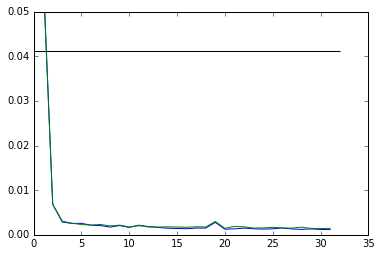

In [7]:
plt.plot(training_error_array)
plt.plot(test_error_array)
plt.ylim(0, 0.05)
plt.hlines(0.0411, 0, training_error_array.shape[0])

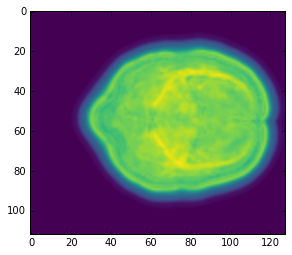

In [10]:
pred_train = TN_utils.predict_original_feature(f_output, fe_vec, norm_coef)
pred_train_vol = pred_train.reshape(vol_shape+(pred_train.shape[1],)).transpose(3, 0, 1, 2)
plt.imshow(np.linalg.norm(pred_train_vol, axis=0)[:, :, 15])

(430080, 31, 1)


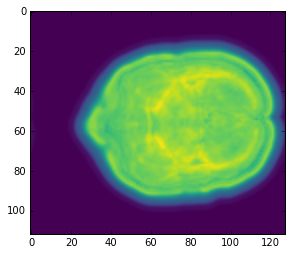

In [12]:
fe_test = TN_utils.load_hardi(i_order=0, i_indiv=1, only_feature=True)
pred_test = TN_utils.predict_original_feature(f_output, fe_test, norm_coef)
pred_test_vol = pred_test.reshape(vol_shape+(pred_test.shape[1],)).transpose(3, 0, 1, 2)
plt.imshow(np.linalg.norm(pred_test_vol, axis=0)[:, :, 15])

In [16]:
sio.savemat('../../../results/hardi_in_ex/Jun7/a0_all_train_1506.mat', {'pred' : pred_train_vol}) 
sio.savemat('../../../results/hardi_in_ex/Jun7/a0_all_test_1507.mat', {'pred' : pred_test_vol})